In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import interpolate, signal
import torch
import torch.nn.functional as tfun

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 8]

# Variable names  {-}

- `I_ref` is the 3D numpy array of the reference (baseline) image. `T_ref` is the 5D tensor of the reference (baseline) image.

- `I_mov` is the 3D numpy array of the moving (followup) image. `T_mov` is the 5D tensor of the moving (followup) image.

- `I_res` is the 3D numpy array of the transformed moving image. `T_res` is the 5D tensor of the transformed moving image.

- For the affine transform - keeping the convention that $A, b$ (in the derivations) or variable names `A, b` denote numpy coordinates and $A', b'$ or variable names `A_prime, b_prime` denote pytorch coordinates. Translation vectors are of shape (3, 1) instead of (3,).

# 4.2 Explore the data in ITK-SNAP (5 points)  {-}

- The 6 combinations (2 transformation models x 3 image similarity metrics) of registration settings all were able to minimize the metric. The difference was between the number of iterations it took to achieve this. Visually, all except Rigid + Cross-correlation (pictured below) looked to have achieved similar results with the segmentation matching across the two images as well.
- Manual registration has a total of 9 tunable parameters (3 each for rotation, translation, and scaling). It is almost impossible to achieve the correct combination of all 9 manually to get correct registration.

![registration](registration.png)

Rigid transformation with cross-correlation metric did not give the best results visually. ![rigidcc](itksnapreg.png) 

All other combinations of transformation models and image similarity metrics achieved similar looking results. ![affine-mi](itksnapreg2.png)

# 4.3 Loading and displaying 3D images with python (10 points) {-}

Writing custom functions to read, write, and view NIfTI images. The view function outputs the axial, sagittal, and coronal views at a given cross-hair location along with the colorbar.

## Read images  {-}

In [2]:
def my_read_nifti(filename):
    """Read NIfTI image voxels and header

    :param filename: path to image to read
    :return: tuple (img, hdr) consisting of numpy voxel array and nibabel NIfTI 
    header
    """    
    img = nib.load(filename)
    
    return img.get_fdata(), img.header

## Write images  {-}

In [3]:
def my_write_nifti(filename, img, header=None):
    """Write NIfTI image voxels and header

    :param filename: path to the image to save
    :param img: numpy voxel array
    :param header: nibabel NIfTI header, defaults to None
    """
    if header is not None:
        nifti_img = nib.Nifti1Image(img, affine=header.get_best_affine(), 
                                    header=header)
    else:
        # defaults to 1mm spacing when header not specified
        nifti_img = nib.Nifti1Image(img, affine=np.ones((len(img.shape), 1)))
        
    nib.save(nifti_img, filename)

## View images  {-}

In [4]:

def my_view(img, xhair=None, header=None, crange=None, cmap='gray', title=None):
    """Display a 3D image in a layout similar to ITK-SNAP

    :param img: 3D voxel array
    :param xhair: crosshair position
    :param header: image header (returned by my_read_nifti), defaults to None
    :param crange: intensity range tuple with min and max values, defaults to 
    None
    :param cmap: colormap (see matplotlib docs), defaults to 'gray'
    """
    vmin = None
    vmax = None
    
    if crange is not None:
        vmin = crange[0]
        vmax = crange[1]

    if xhair is None:
        xhair = (int(img.shape[0]/2), int(img.shape[1]/2), int(img.shape[2]/2))
            
    fig, ax = plt.subplots(2, 2)

    im1 = ax[0, 0].imshow(img[:, :, xhair[2]], cmap=cmap, vmin=vmin, vmax=vmax)

    # need to transpose each image and invert axes to get the correct
    # orientations of the views

    # axial view (y, x)
    ax[0, 0].imshow(img[:, :, xhair[2]].transpose(), cmap=cmap, vmin=vmin, 
                    vmax=vmax)
    ax[0, 0].invert_xaxis()
    ax[0, 0].invert_yaxis()
    ax[0, 0].axvline(xhair[0])
    ax[0, 0].axhline(xhair[1])
    
    # sagittal view (z, y)
    ax[0, 1].imshow(img[xhair[0], :, :].transpose(), cmap=cmap, vmin=vmin, 
                    vmax=vmax)
    ax[0, 1].invert_xaxis()
    ax[0, 1].invert_yaxis()
    ax[0, 1].axvline(xhair[1])
    ax[0, 1].axhline(xhair[2])
    
    # colorbar
    ax[1, 0].axis('off')
    cax = plt.axes([0.175, 0.15, 0.3, 0.05])
    plt.colorbar(im1, orientation='horizontal', ax=ax[0,0], cax=cax)

    # coronal view (z, x)
    ax[1, 1].imshow(img[:, xhair[1], :].transpose(), cmap=cmap, vmin=vmin, 
                    vmax=vmax)
    ax[1, 1].invert_xaxis()
    ax[1, 1].invert_yaxis()
    ax[1, 1].axvline(xhair[0])
    ax[1, 1].axhline(xhair[2])
    
    # extract the correct aspect ratios from header information
    if header is not None:
        # pixdim[1] is spacing in x
        # pixdim[2] is spacing in y
        # pixdim[3] is spacing in z
        ax[0, 0].set_aspect(header['pixdim'][2]/header['pixdim'][1])
        ax[0, 1].set_aspect(header['pixdim'][3]/header['pixdim'][2])
        ax[1, 1].set_aspect(header['pixdim'][3]/header['pixdim'][1])
        
    fig.suptitle(f"{title} \nxhair loc {xhair}")

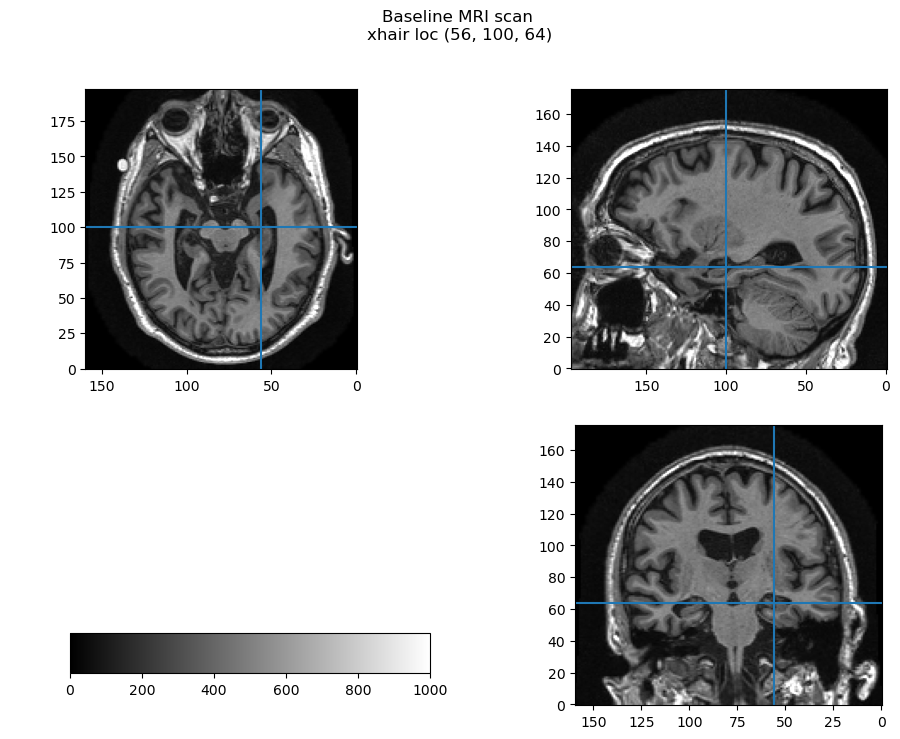

In [5]:
# read in baseline image
img, hdr = my_read_nifti("data/baseline.nii")

my_view(img, xhair=(56,100,64), header=hdr, crange=(0, 1000),
        title="Baseline MRI scan")

# 5.1 Apply affine transformations to 3D images (10 points)  {-}
Extract the transform matrix and translation vector from file. Apply the transformation to meshgrid coordinates to get the transformed coordinates. Interpolate the moving image to get voxel values at the transformed coordinates. This is the resampled, transformed image.

## Read transform from file  {-}

In [6]:
def my_read_transform(filename):
    """Read 3D transform (4x4 matrix) from file

    :param filename: file containing transform matrix
    :return: tuple (A, b) where A is 3x3 affine matrix, b is translation vector
    """
    Ab = np.loadtxt(filename)
    
    A = Ab[:3, :3]
    b = np.expand_dims(Ab[:3, 3], axis=1) # dimension (3, 1) instead of (3,)
    
    return A, b 

## Apply transform to image  {-}

In [7]:
def my_transform_image(I_ref, I_mov, A, b, method='linear', fill_value=0):
    """Transform a moving image into the space of the fixed field

    :param I_ref: 3D voxel array of the fixed (reference) image
    :param I_mov: 3D voxel array of the moving image
    :param A: 3x3 affine transformation matrix
    :param b: 3x1 translation vector
    :param method: interpolation method, defaults to 'linear'
    :param fill_value: value with which to replace missing values, defaults to 0
    :return: 3D voxel array of the affine-transformed moving image
    """
    # get number of points along each dimension
    nx, ny, nz = I_ref.shape
    x = np.linspace(0, nx-1, nx)
    y = np.linspace(0, ny-1, ny)
    z = np.linspace(0, nz-1, nz)

    # generate 3D grid coordinates
    xp, yp, zp = np.meshgrid(x, y, z, indexing='ij')
    Xp = np.stack((xp, yp, zp))
    
    Xp = np.reshape(Xp, newshape=(3, -1))

    # T(Xp) = A*Xp + b
    TXp = np.dot(A, Xp) + b

    I_res = interpolate.interpn((x, y, z), I_mov, TXp.T, method=method, 
                                bounds_error=False, fill_value=fill_value)
    
    I_res = np.reshape(I_res, newshape=I_ref.shape)

    return I_res    

In [8]:
# read in baseline image
I_ref, hdr_ref = my_read_nifti("data/baseline.nii")
# read in follow up image
I_mov, hdr_mov = my_read_nifti("data/followup.nii")

# read in transform matric
A, b = my_read_transform("data/f2b.txt")

# get transformed image
I_res = my_transform_image(I_ref, I_mov, A, b)

### View resampled follow up image  {-}

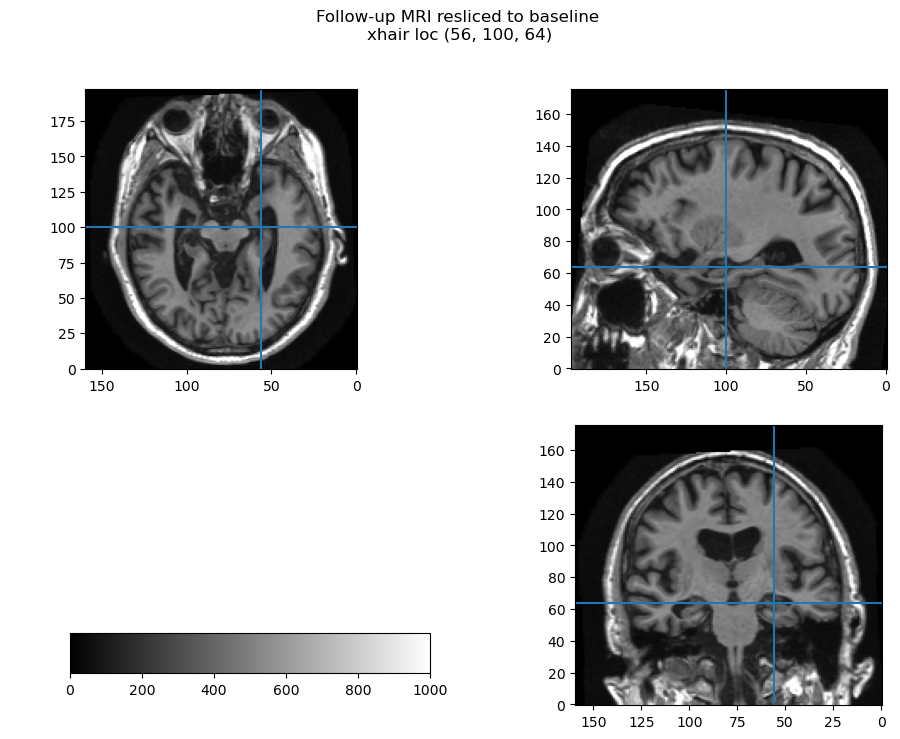

In [9]:
my_view(I_res, xhair=(56,100,64), header=hdr_mov, crange=(0, 1000),
        title="Follow-up MRI resliced to baseline")

### View baseline image  {-}

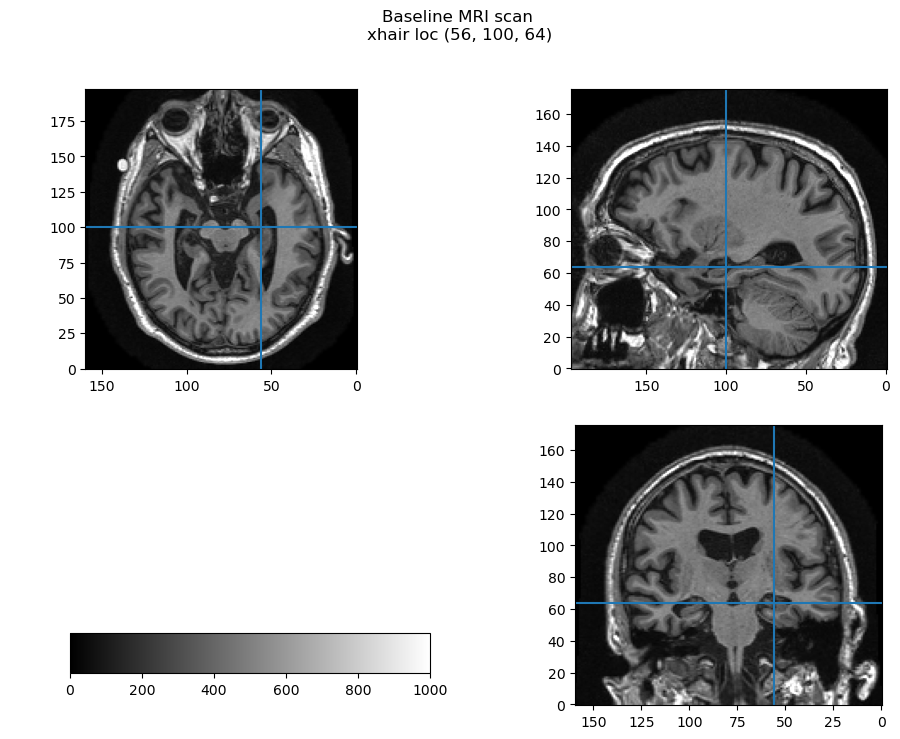

In [10]:
my_view(I_ref, xhair=(56,100,64), header=hdr_ref, crange=(0, 1000),
        title="Baseline MRI scan")

# 5.2 Effects of low pass filtering on difference image computation (15 points)  {-}
Implement Gaussian and mean low pass filters. Examine how low pass filtering affects the computation of differences between the baseline image and the affine-transformed followup image.

## Implement Gaussian low-pass filtering for 3D volumes  {-}

In [11]:
def my_gaussian_lpf(image, sigma):
    """Apply 3D Gaussian low-pass filtering to an image

    :param image: 3D voxel array of the input image
    :param sigma: std dev of the Gaussian kernel in voxel units
    :return: 3D voxel array of the filtered image
    """
    # generate sample points and compute the value of Gaussian at these points
    # the number of sample points is determined from the sigma value
    halfsize = int(np.ceil(3.5 * sigma))
    x = np.linspace(-halfsize, halfsize, 2*halfsize+1)
    
    # compute the values
    # this gives us a 1D Gaussian
    G = np.exp(-np.power(x/sigma, 2) / 2)/(sigma * np.sqrt(2*np.pi))
    
    # generate Gaussians along each dimension
    Gz = np.expand_dims(G, axis=(1, 0)) # (1, 1, size)
    Gy = np.expand_dims(G, axis=(2, 0)) # (1, size, 1)
    Gx = np.expand_dims(np.expand_dims(G, axis=1), axis=1) # (size, 1, 1)

    G = Gx * Gy * Gz # 3D Gaussian (size, size, size)
    
    # convolve (using FFT for the more optimal implementation) image signal
    # with the Gaussian filter to get lowpass filtered image
    lpf_img = signal.fftconvolve(image, G, mode='same')
    
    return lpf_img

### Visualize Gaussian low pass filtered delta signal  {-}

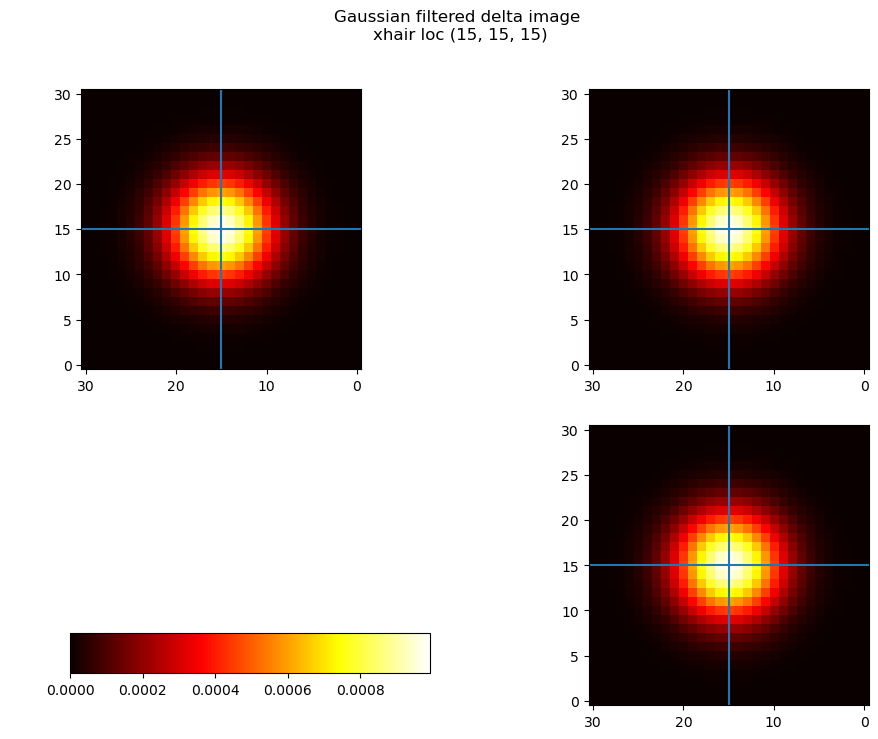

In [12]:
# generate delta function image 
# all pixels except the center are 0, center pixel is 1
delta = np.zeros(shape=(31, 31, 31))
delta[15, 15, 15] = 1

lpf_delta = my_gaussian_lpf(delta, sigma=4)

my_view(lpf_delta, cmap='hot', title="Gaussian filtered delta image")

### Baseline image filtered with Gaussian filter at sigma = 2{-}


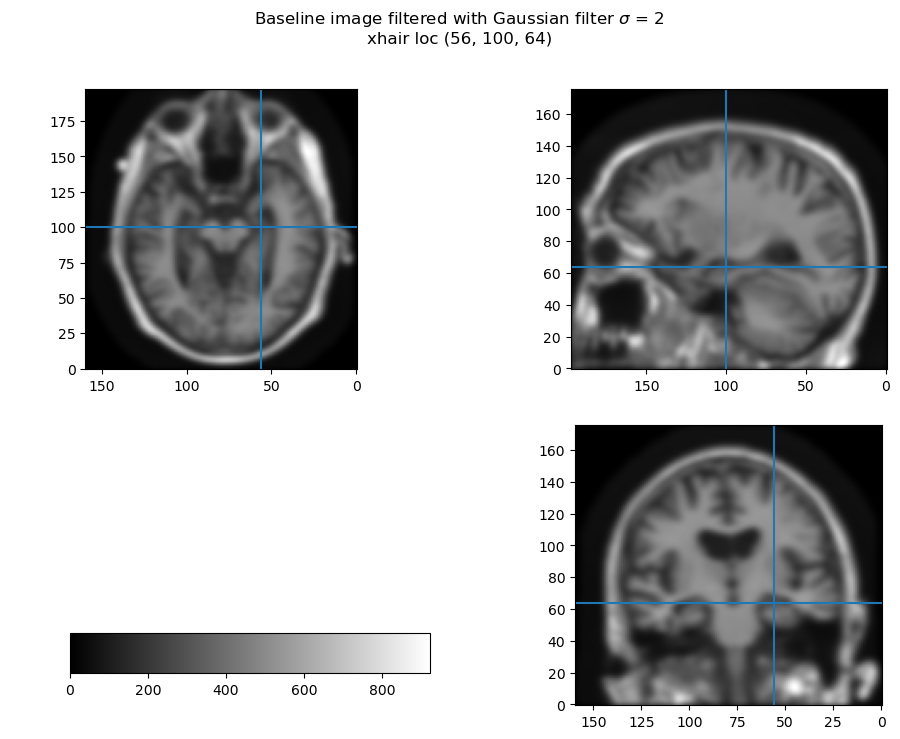

In [13]:
I_ref_gaussian_lpf = my_gaussian_lpf(I_ref, sigma=2)

my_view(I_ref_gaussian_lpf, xhair=(56,100,64), header=hdr_ref, 
        title="Baseline image filtered with Gaussian filter $\sigma$ = 2")

## Implement mean filtering  {-}

In [14]:
def my_mean_lpf(image, radius):
    """Apply 3D mean filtering to an image

    :param image: 3D voxel numpy array
    :param radius: size of the mean filter
    :return: mean filtered image
    """    
    size = int(2*radius + 1)
    mean_lpf = np.ones(shape=(size, size, size))/size**3
    
    mean_lpf_image = signal.fftconvolve(image, mean_lpf, mode='same')
    
    return mean_lpf_image

### Baseline image filtered with mean filter radius=2  {-}

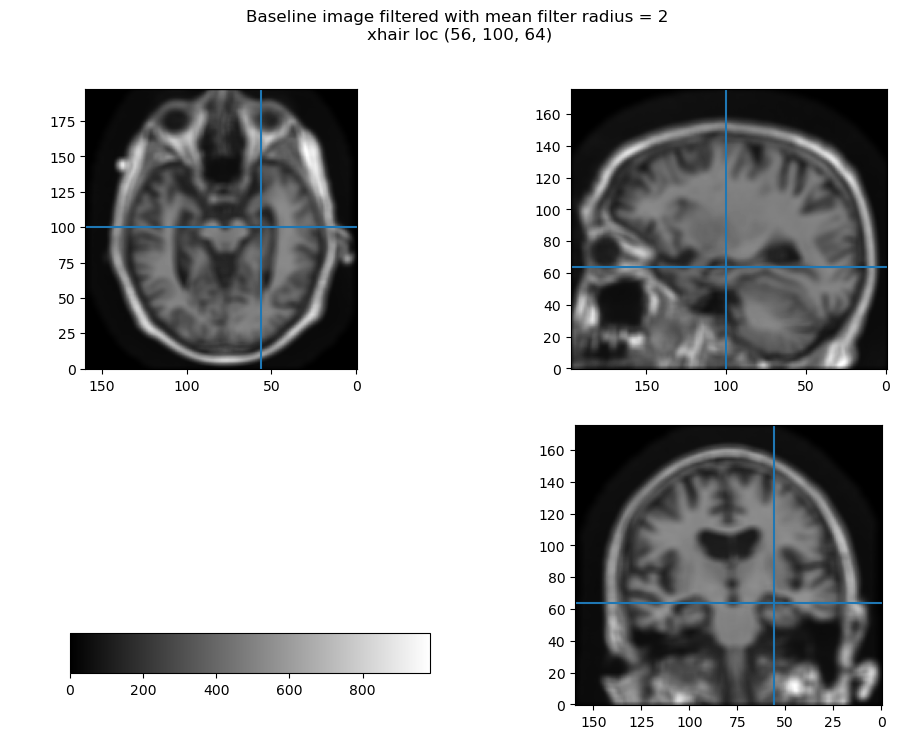

In [15]:
I_ref_mean_lpf = my_mean_lpf(I_ref, radius=2)

my_view(I_ref_mean_lpf, xhair=(56,100,64), header=hdr_ref,
        title="Baseline image filtered with mean filter radius = 2")

## Compute and show difference images  {-}

$K_B$ is the preprocessing done on the baseline image. $K_F$ is the preprocessing done on the follow-up image before resampling.  
The difference image is $D(\textbf{x}) = R[(I_F \circ K_F)](\textbf{x}) - (I_B \circ K_B)(\textbf{x})$

### $K_B$ = None, $K_F$ = None, Interpolation = Nearest neighbor {-}

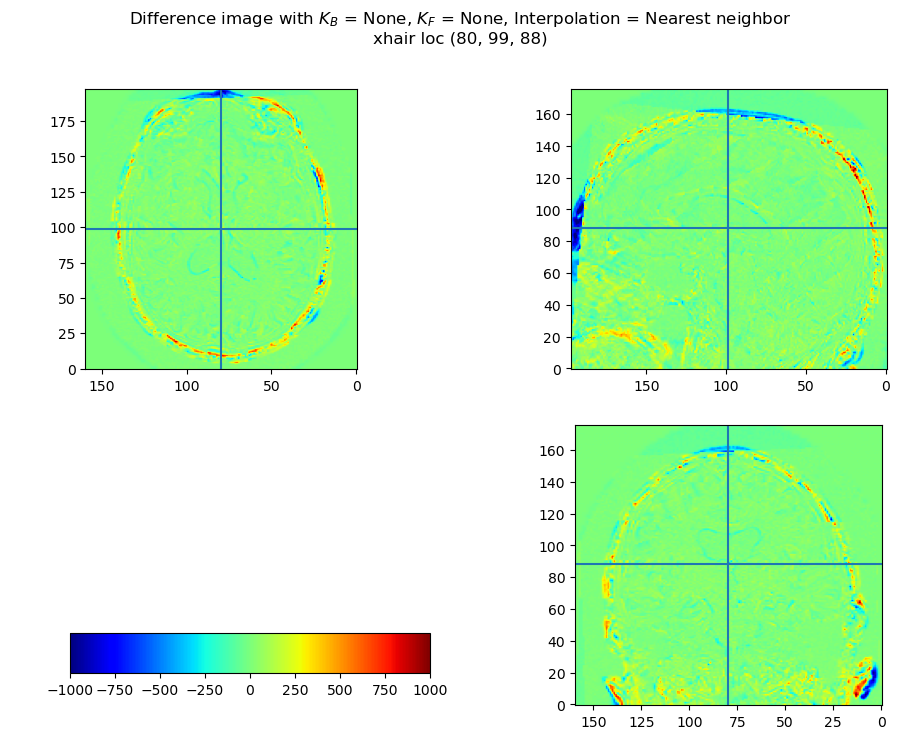

In [16]:
diff1 = my_transform_image(I_ref, I_mov, A, b, method='nearest') - I_ref

my_view(diff1, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = None, $K_F$ = None, Interpolation = Nearest neighbor")

### 2. $K_B$ = None, $K_F$ = None, Interpolation = Linear  {-}

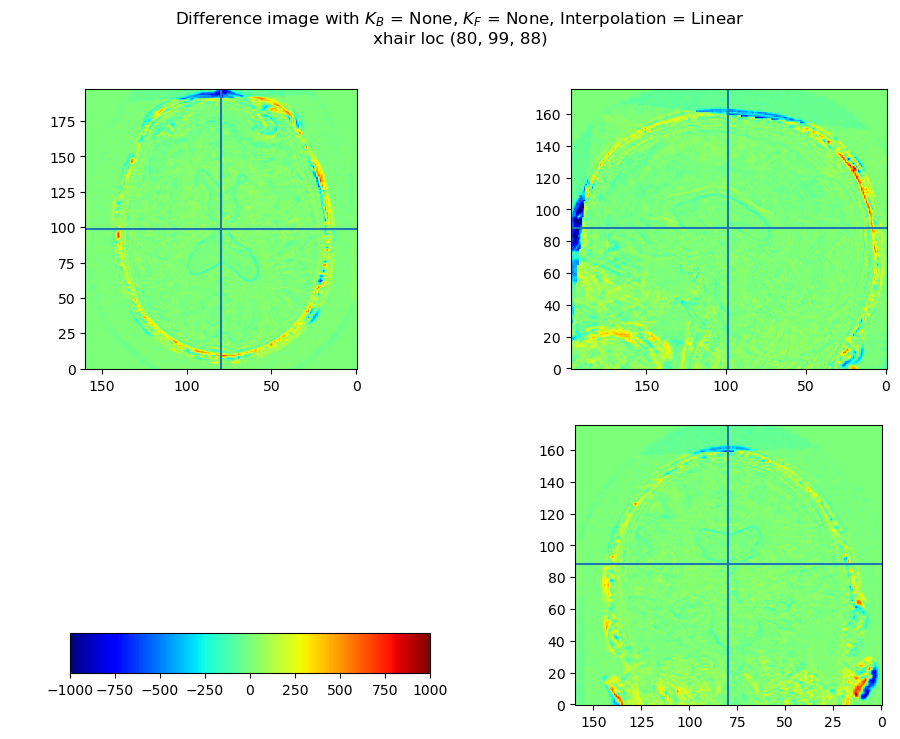

In [17]:
diff2 = my_transform_image(I_ref, I_mov, A, b, method='linear') - I_ref

my_view(diff2, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = None, $K_F$ = None, Interpolation = Linear")

### 3. $K_B$ = Gaussian sigma=2, $K_F$ = Gaussian sigma=2, Interpolation = Linear  {-}

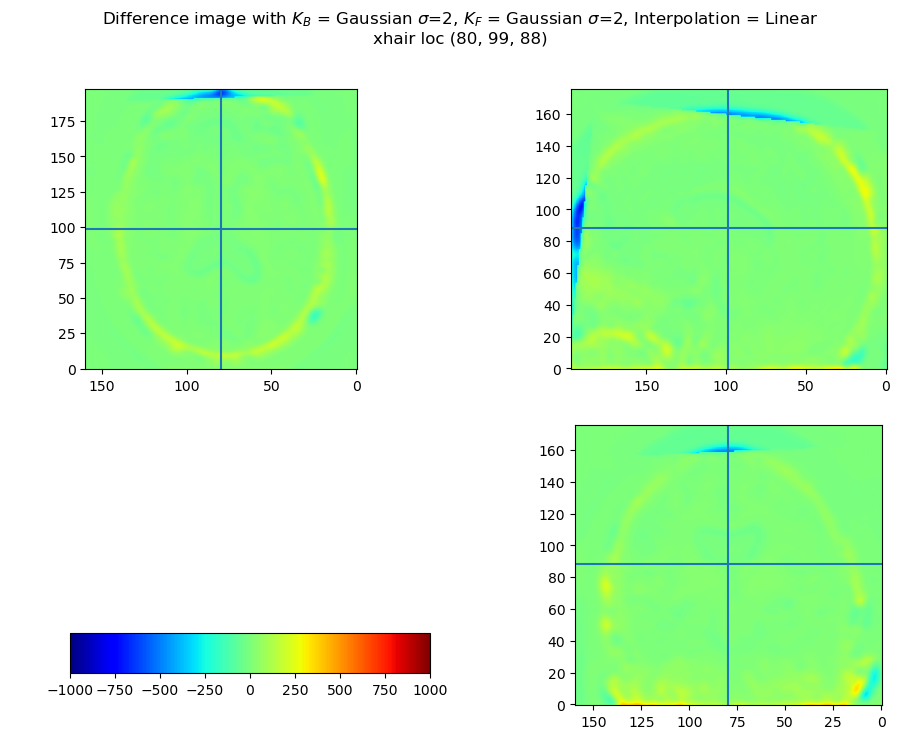

In [18]:
I_ref_lpf = my_gaussian_lpf(I_ref, sigma=2)
I_mov_lpf = my_gaussian_lpf(I_mov, sigma=2)

diff3 = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf

my_view(diff3, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = Gaussian $\sigma$=2, $K_F$ = Gaussian $\sigma$=2, Interpolation = Linear")

### 4. $K_B$ = Mean radius=2, $K_F$ = Mean radius=2, Interpolation = Linear  {-}

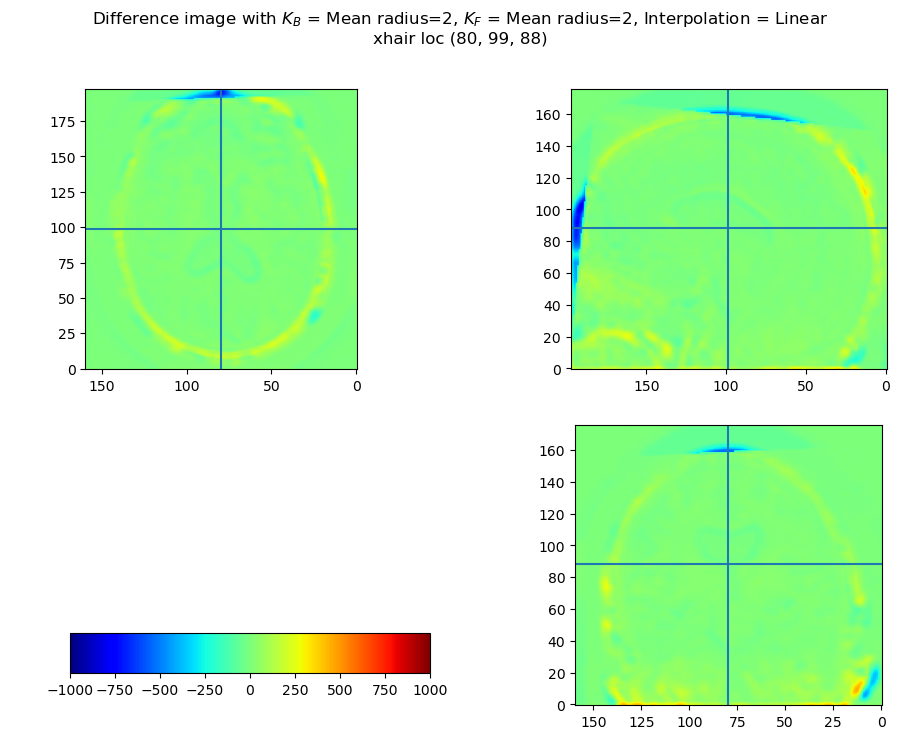

In [19]:
I_ref_lpf = my_mean_lpf(I_ref, radius=2)
I_mov_lpf = my_mean_lpf(I_mov, radius=2)

diff4 = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf

my_view(diff4, header=hdr_ref, crange=(-1000, 1000), cmap='jet',
        title="Difference image with $K_B$ = Mean radius=2, $K_F$ = Mean radius=2, Interpolation = Linear")

# 5.3 Quantify intensity difference over regions of interest (10 points)  {-}

In [20]:
def my_rms_over_roi(image, seg, label):
    """Compute RMS of a difference image over a label in the segmentation

    :param image: 3D voxel array of the difference image
    :param seg: 3D voxel array with segmentation labels
    :param label: segmentation label
    :return: RMS over ROI
    """
    # binary segmentation mask
    I_seg_mask = np.where(seg==label, 1, 0)
    size_ROI = I_seg_mask.sum()
    
    # difference image of ROI - only relevant pixels are non-zero
    # obtained by an element-wise multiplication with the roi mask
    diff_roi = np.multiply(image, I_seg_mask)

    diff_roi_squared = np.square(diff_roi)
    
    rms_over_roi = np.sqrt(diff_roi_squared.sum()/size_ROI)
    
    return rms_over_roi    

In [21]:
I_seg, hdr_seg = my_read_nifti("data/seg.nii")

labels = [1, 2, 3]
anatomical_labels = ["Left Hippocampus", "Right Hippocampus", 
                     "Lateral Ventricles"]

## RMS over ROI for Gaussian filter with sigma values from 0.5 to 5.0  {-}

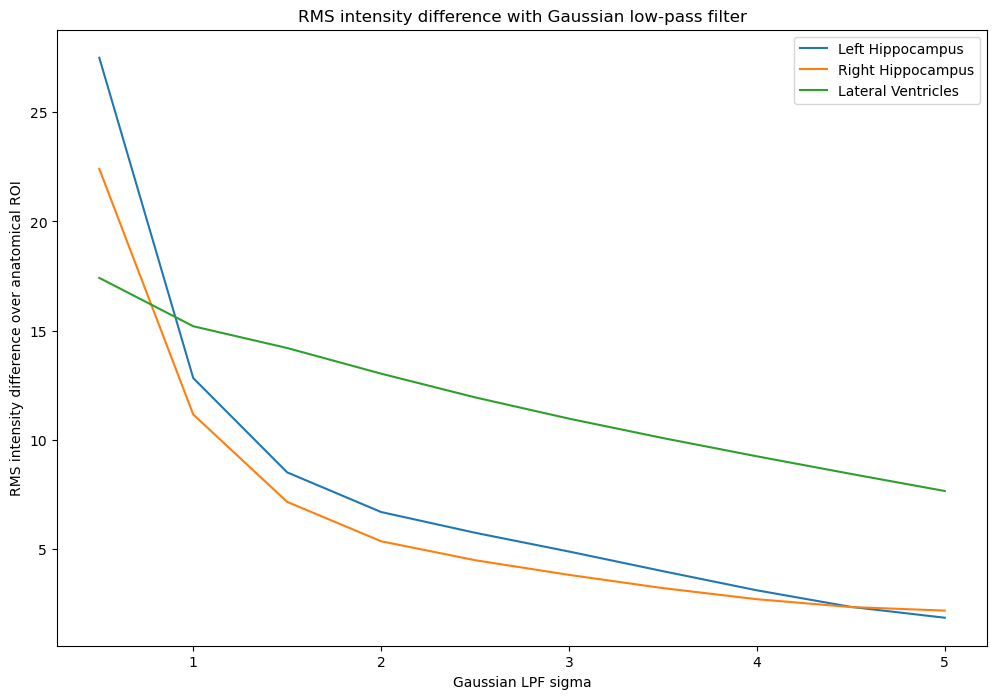

In [22]:
fig, ax = plt.subplots()

sigma_values = np.arange(0.5, 5.5, 0.5)

for label in labels:
    all_rms_over_roi = []
    for sigma in sigma_values:
        I_ref_lpf = my_gaussian_lpf(I_ref, sigma=sigma)
        I_mov_lpf = my_gaussian_lpf(I_mov, sigma=sigma)

        diff = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf
        
        rms_over_roi = my_rms_over_roi(diff, I_seg, label)
        
        all_rms_over_roi.append(rms_over_roi)
    
    ax.plot(sigma_values, all_rms_over_roi, label=f"{anatomical_labels[label-1]}")
    ax.set_title("RMS intensity difference with Gaussian low-pass filter")
    ax.set_xlabel("Gaussian LPF sigma")
    ax.set_ylabel("RMS intensity difference over anatomical ROI")
    ax.legend()

plt.show()    
    

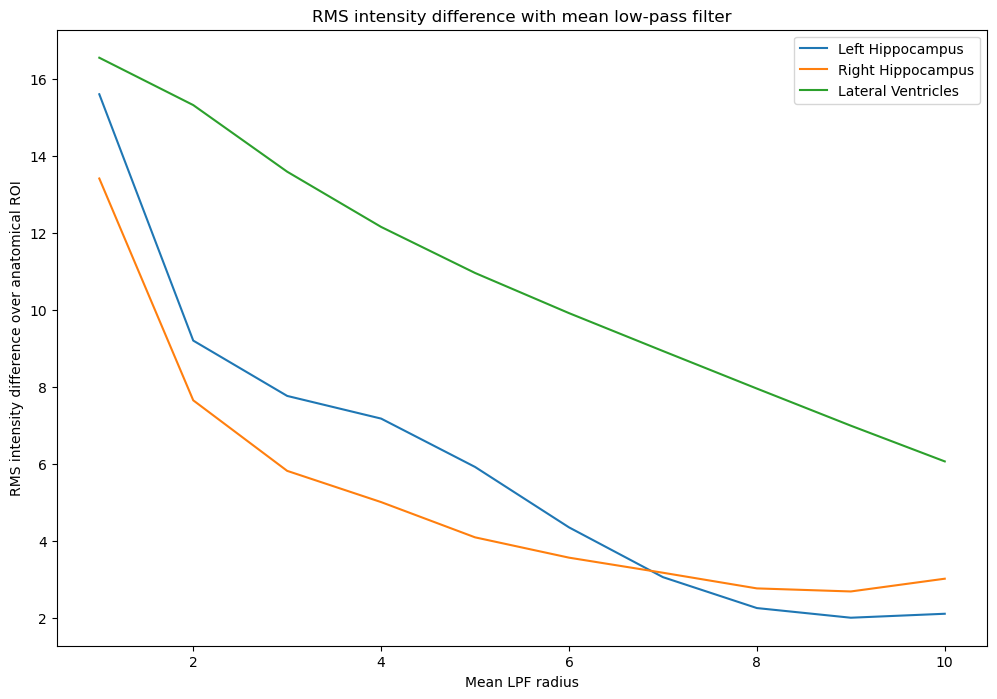

In [23]:
fig, ax = plt.subplots()

radius_values = np.arange(1, 11, 1)

for label in labels:
    all_rms_over_roi = []
    for radius in radius_values:
        I_ref_lpf = my_mean_lpf(I_ref, radius=radius)
        I_mov_lpf = my_mean_lpf(I_mov, radius=radius)

        diff = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf
        
        rms_over_roi = my_rms_over_roi(diff, I_seg, label)
        
        all_rms_over_roi.append(rms_over_roi)
    
    ax.plot(radius_values, all_rms_over_roi, label=f"{anatomical_labels[label-1]}")
    ax.set_title("RMS intensity difference with mean low-pass filter")
    ax.set_xlabel("Mean LPF radius")
    ax.set_ylabel("RMS intensity difference over anatomical ROI")
    ax.legend()

plt.show()    
    

## Explanation {-}

We are blurring the images when we apply the low pass filter. Higher the sigma or radius, higher is the blurring. The way these low pass filters work, is replacing the pixel value (or intensity) with an intensity value that is a function of the neighboring pixel values. With higher blurring, the intensity difference in adjacent pixels is reduced. Hence the RMS intensity difference in the low pass filtered baseline and reconstructed image also reduced as the blurring radius increases. The right and left hippocampus are almost symmetric ROIs, hence their plots follow almost same trends. The lateral ventricle is comparatively larger ROI and mostly appears black in the 3D image i.e. it does not contain too much high frequency information to begin with. Hence, the RMS intensity difference with low pass filters for the ventricles is not as sharply declining plot as compared to the hippocampi.

# 6.1 Loading 3D images into pytorch tensors (5 points)  {-}

In [24]:
T_ref = torch.from_numpy(I_ref).unsqueeze(0).unsqueeze(0)
print(T_ref.dtype)
print(T_ref.shape)

torch.float64
torch.Size([1, 1, 160, 198, 176])


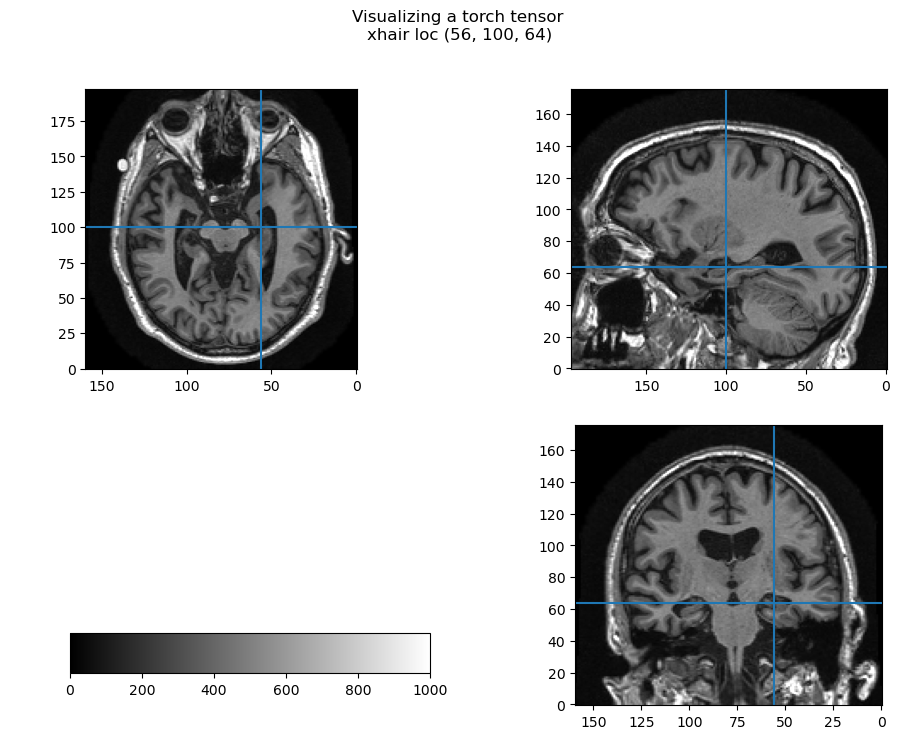

In [25]:
my_view(T_ref.squeeze().detach().cpu().numpy(), xhair=(56,100,64), 
        header=hdr_ref, crange=(0,1000), title="Visualizing a torch tensor")

# 6.2 Applying affine transformations in pytorch (15 points)  {-}

## Numpy to PyTorch  {-}

$W, A, \textbf{b}, \textbf{z}$ are known entities.
 
$$ W(A\textbf{x} + \textbf{b}) + \textbf{z} = A'(W\textbf{x} + \textbf{z}) +\textbf{b}' \>\>\>\>\> \forall \textbf{x} \in \mathbb{R} $$

$$ WA\textbf{x} + W\textbf{b} + \textbf{z} = A'W\textbf{x} + A'\textbf{z} +\textbf{b}' \>\>\>\>\> \ldots (1) $$

Since this expression is true $\forall \textbf{x} \in \mathbb{R}$, we have:

$$ WA = A'W $$
$$ WAW^{-1} = A'WW^{-1} $$
$$ WAW^{-1} = A'I $$
$$ A' = WAW^{-1} $$

Substituting known value of $A'$ in $(1)$, we have:

$$ W\textbf{b} + \textbf{z} = A'\textbf{z} + \textbf{b}' $$
$$ \textbf{b}' = W\textbf{b} + \textbf{z} - A'\textbf{z} $$

In [26]:
def my_numpy_affine_to_pytorch_affine(A, b, img_shape):
    """Convert affine transform (A,b) from numpy to pytorch coordinates

    :param A: 3x3 affine matrix in numpy coordinates
    :param b: 3x1 translation vector in numpy coordinates
    :param img_shape: size of the image to be transformed
    :return: converted affine transform in pytorch coordinates
    """
    (Sx, Sy, Sz) = img_shape
    W = np.array([[0, 0, 2/Sz], [0, 2/Sy, 0], [2/Sx, 0, 0]]) # shape (3,3)
    z = np.array([[1/Sz - 1], [1/Sy - 1], [1/Sx - 1]]) # shape (3,1)
    
    A_prime = np.dot(np.dot(W, A), np.linalg.inv(W))
    
    b_prime = np.dot(W, b) + z - np.dot(A_prime, z) 
    
    return A_prime, b_prime


In [27]:
A_prime, b_prime = my_numpy_affine_to_pytorch_affine(A, b, I_ref.shape)
A_prime, b_prime

(array([[ 0.9939    , -0.120375  ,  0.04881818],
        [ 0.08791111,  1.001     ,  0.03361616],
        [-0.04499   , -0.0314325 ,  1.0003    ]]),
 array([[ 0.18924318],
        [ 0.06270253],
        [-0.00460125]]))

## PyTorch to Numpy  {-}

$W, A', \textbf{b}', \textbf{z}$ are known entities.
 
$$ W(A\textbf{x} + \textbf{b}) + \textbf{z} = A'(W\textbf{x} + \textbf{z}) +\textbf{b}' \>\>\>\>\> \forall \textbf{x} \in \mathbb{R} $$

$$ WA\textbf{x} + W\textbf{b} + \textbf{z} = A'W\textbf{x} + A'\textbf{z} +\textbf{b}' \>\>\>\>\> \ldots (2) $$

Since this expression is true $\forall \textbf{x} \in \mathbb{R}$, we have:

$$ WA = A'W $$
$$ W^{-1}WA = W^{-1}A'W $$
$$ IA = W^{-1}A'W $$
$$ A = W^{-1}A'W $$

From $(2)$, we have:

$$ W\textbf{b} + \textbf{z} = A'\textbf{z} + \textbf{b}' $$
$$ W\textbf{b} = A'\textbf{z} + \textbf{b}' - \textbf{z} $$
$$ W^{-1}W\textbf{b} = W^{-1}(A'\textbf{z} + \textbf{b}' - \textbf{z}) $$
$$ I\textbf{b} = W^{-1}(A'\textbf{z} + \textbf{b}' - \textbf{z}) $$
$$ \textbf{b} = W^{-1}(A'\textbf{z} + \textbf{b}' - \textbf{z}) $$

In [28]:
def my_pytorch_affine_to_numpy_affine(A_prime, b_prime, img_shape):
    """Convert affine transform (A',b') from pytorch to numpy coordinates

    :param A_prime: 3x3 affine matrix in pytorch coordinates
    :param b_prime: 3x1 translation vector in pytorch coordinates
    :param img_shape: size of the image to be transformed
    :return: converted affine transform in numpy coordinates
    """
    (Sx, Sy, Sz) = img_shape
    W = np.array([[0, 0, 2/Sz], [0, 2/Sy, 0], [2/Sx, 0, 0]]) # shape (3,3)
    z = np.array([[1/Sz - 1], [1/Sy - 1], [1/Sx - 1]]) # shape (3,1)
    
    W_inv = np.linalg.inv(W)
    
    A = np.dot(np.dot(W_inv, A_prime), W)
    
    b = np.dot(W_inv, (np.dot(A_prime, z) + b_prime - z))
    
    return A, b

In [29]:
A, b = my_pytorch_affine_to_numpy_affine(A_prime, b_prime, I_ref.shape)
A, b

(array([[ 1.0003, -0.0254, -0.0409],
        [ 0.0416,  1.001 ,  0.0989],
        [ 0.0537, -0.107 ,  0.9939]]),
 array([[ 5.6887],
        [-5.8519],
        [23.4575]]))

## Function to apply affine transform  {-}

In [30]:
def my_transform_image_pytorch(T_ref, T_mov, T_A, T_b, mode='bilinear', 
                               padding_mode='zeros'):
    """Apply an affine transformation to 3D images represented as PyTorch 
    tensors.

    :param T_ref: 5D tensor of fixed (ref) image 
    :param T_mov: 5D tensor of moving (followup) image
    :param T_A: 3x3 affine matrix in PyTorch coordinate space
    :param T_b: 3x1 translation vector in PyTorch coordinate space
    :param mode: interpolation mode, defaults to 'bilinear'
    :param padding_mode: padding mode, defaults to 'zeros'
    :return: 5D tensor of transformed moving image
    """ 
    N = 1
    C = 3
    (D, H, W) = T_ref.shape[2:] # (160, 198, 176)

    # --------- working solution do not touch -------------#
    
    # concatenated transformation matrix
    # theta shape (N, 3, 4)
    theta = torch.cat((T_A, T_b), 1).unsqueeze(0) 
    
    # Xp shape [N, D, H, W, 3]    
    Xp = tfun.affine_grid(theta, size=(N, C, D, H, W), align_corners=False) 
    
    T_res = tfun.grid_sample(T_mov, Xp, mode=mode, padding_mode=padding_mode, 
                             align_corners=False)
    
    # --------- working solution do not touch -------------#
    
    # this part tries following the same logic as the numpy implementation
    # however, there is some shape mismatch that messes up the matrix 
    # multiplication I tried debugging this for over a week and also talked to 
    # the TAs but wasn't able to solve it. It seems like a lot of other people 
    # have had similar issues as discussed on Ed discussions and there hasn't 
    # been a solution at the time of me submitting this assignment.
    #
    # is this relevant?
    # https://github.com/pytorch/pytorch/issues/35775#issuecomment-705702703
    
    # Xp = tfun.affine_grid(torch.ones(3,4).unsqueeze(0), size=(N, C, D, H, W), 
    #                       align_corners=False) # Xp shape [N, D, H, W, 3]
    # Xp_reshaped = torch.reshape(Xp, shape=(-1, 3))
    
    # print(Xp_reshaped.shape)
    # print(T_A.shape)
    
    # TXp = torch.mm(T_A, Xp_reshaped.T) + T_b   
    
    # print(TXp.shape)
    
    # TXp_tmp = torch.reshape(TXp, shape=(-1, 3))
    # print(TXp_tmp.shape)
    # TXp_reshaped = torch.reshape(TXp_tmp, shape=Xp.shape)
        
    # T_res = tfun.grid_sample(T_mov.float(), TXp_reshaped, mode=mode, 
    #                          padding_mode=padding_mode, align_corners=False)
        
    return T_res
     

In [31]:
T_mov = torch.from_numpy(I_mov).unsqueeze(0).unsqueeze(0)

T_A = torch.tensor(A_prime)
T_b = torch.tensor(b_prime)

T_res = my_transform_image_pytorch(T_ref, T_mov, T_A, T_b)

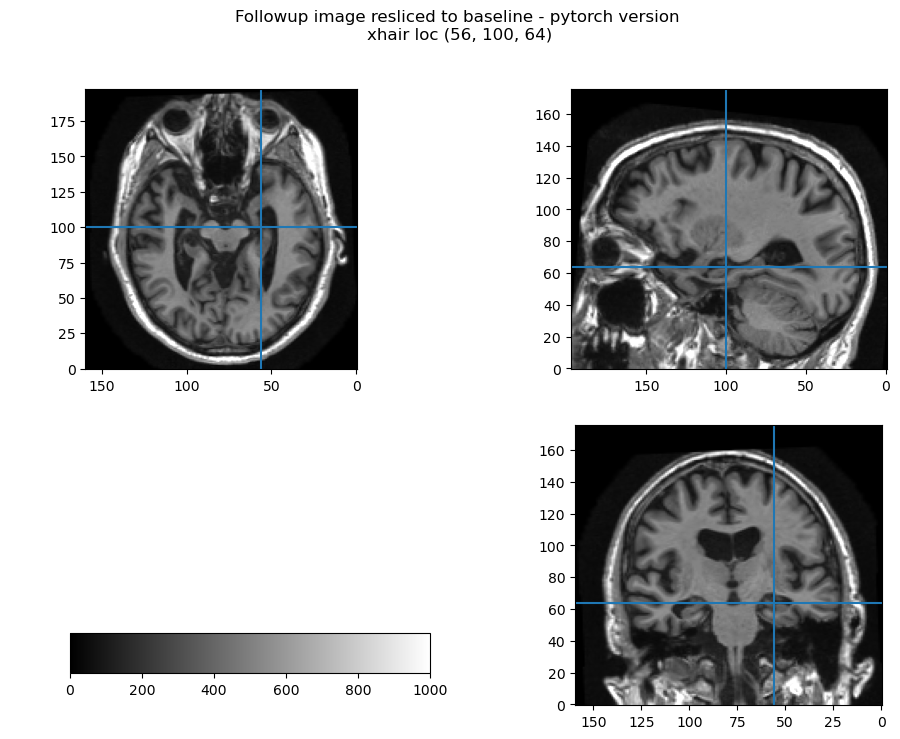

In [32]:
my_view(T_res.squeeze().detach().cpu().numpy(), xhair=(56,100,64), 
        header=hdr_mov, crange=(0,1000),
        title="Followup image resliced to baseline - pytorch version")

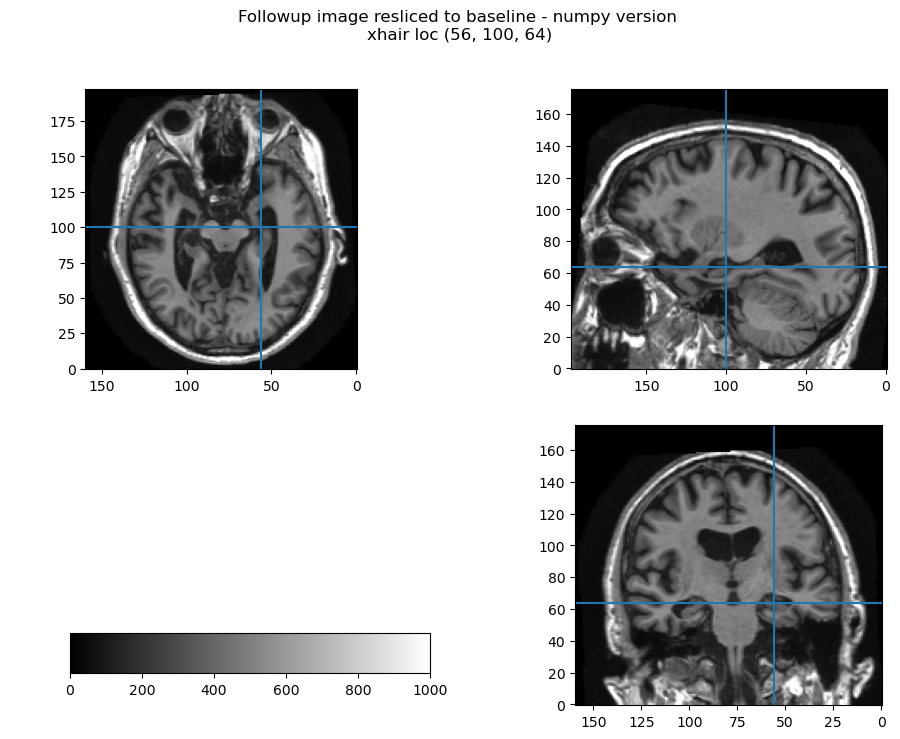

In [33]:
my_view(I_res, xhair=(56,100,64), header=hdr_mov, crange=(0, 1000),
        title="Followup image resliced to baseline - numpy version")

In [34]:
I_diff = I_res - T_res.squeeze().detach().cpu().numpy()

for label in (1,2,3):
    print(f"RMS over label {label}, is {my_rms_over_roi(I_diff, I_seg, label)}")

RMS over label 1, is 9.898406182697044e-13
RMS over label 2, is 1.0949252760355945e-12
RMS over label 3, is 8.408149659801579e-13


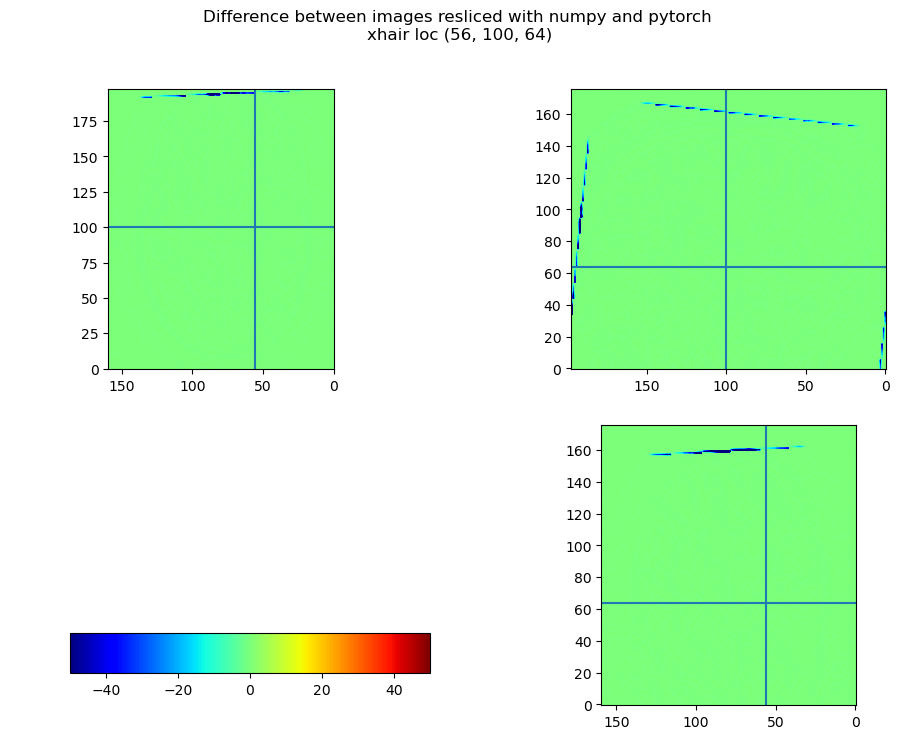

In [35]:
my_view(I_diff, xhair=(56, 100, 64), crange=(-50, 50), cmap='jet', 
        title="Difference between images resliced with numpy and pytorch")

# 6.3 Affine registration using LBFGS optimizer (10 points)  {-}

## Objective function for affine registration  {-}

In [36]:
def my_affine_objective_fn(T_ref, T_mov, T_A, T_b):
    """Compute the affine registration objective function.

    :param T_ref: 5D tensor of reference (fixed) image
    :param T_mov: 5D tensor of followup (moving) image
    :param T_A: 3x3 affine matrix in PyTorch coordinate space
    :param T_b: 3x1 translation vector in PyTorch coordinate space
    :return: RMS differnece between the reference image and transformed moving 
    image
    """
    T_res = my_transform_image_pytorch(T_ref, T_mov, T_A, T_b)
    
    # pytorch built-in function to computer mean squared loss
    criterion = torch.nn.MSELoss()
    
    loss = torch.sqrt(criterion(T_ref, T_res))
    
    # in-place function to make sure gradient tracked on the loss
    loss.requires_grad_()

    return loss

In [37]:
# Create tensors T_A and T_b and track their partial derivatives
T_A = torch.tensor(A_prime, requires_grad=True) 
T_b = torch.tensor(b_prime, requires_grad=True)

# Compute the objective function (forward pass)
obj = my_affine_objective_fn(T_ref, T_mov, T_A, T_b)

# Compute the partial derivatives of the objective function with respect to 
# elements of T_A and T_b automatically (backward pass)
obj.backward()

# Print the objective function value and partial derivatives
obj, T_A.grad, T_b.grad

(tensor(87.0636, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 tensor([[-14.9920, -78.1983,  29.2935],
         [ 52.9782, 164.1723,   3.8241],
         [-37.4395,  42.8367, -68.0659]], dtype=torch.float64),
 tensor([[ 105.6441],
         [-576.0894],
         [ 329.3974]], dtype=torch.float64))

In [38]:
# Starting point for optimization - identity affine transform. Note that 
# the LBFGS implementation in PyTorch requires all the parameters (i.e. 
# variables that we are optimizing over) to be contained in a single
# tensor, which we call T_opt
T_opt = torch.tensor(np.eye(3,4), requires_grad=True)

# Objective function for optimization, a wrapper around my_affine_objective_fn
f_opt = lambda : my_affine_objective_fn(T_ref, T_mov, T_opt[0:3,0:3], 
                                        T_opt[0:3,3].unsqueeze(1))

# Initialize the LBFGS optimizer with a line search routine
optimizer = torch.optim.LBFGS([T_opt], history_size=10, max_iter=4, 
                              line_search_fn="strong_wolfe")

# Keep track of the objective function values over the course of optimization
opt_history = []

# Run for a few iterations
for i in range(50):
    optimizer.zero_grad()
    objective = f_opt()
    objective.backward()
    optimizer.step(f_opt) 
    opt_history.append(objective.item())
    print('Iter %03d Obj %8.4f' % (i, objective.item()))

Iter 000 Obj 257.0808
Iter 001 Obj 245.0047
Iter 002 Obj 204.0881
Iter 003 Obj 179.8948
Iter 004 Obj 178.8143
Iter 005 Obj 171.0298
Iter 006 Obj 162.0617
Iter 007 Obj 158.8621
Iter 008 Obj 154.1730
Iter 009 Obj 152.7394
Iter 010 Obj 151.7410
Iter 011 Obj 147.4679
Iter 012 Obj 140.7471
Iter 013 Obj 126.1348
Iter 014 Obj 114.9429
Iter 015 Obj 103.2255
Iter 016 Obj  96.2325
Iter 017 Obj  93.0578
Iter 018 Obj  88.8899
Iter 019 Obj  87.5956
Iter 020 Obj  87.1054
Iter 021 Obj  86.9795
Iter 022 Obj  86.7013
Iter 023 Obj  86.5596
Iter 024 Obj  86.4550
Iter 025 Obj  86.4329
Iter 026 Obj  86.4278
Iter 027 Obj  86.4262
Iter 028 Obj  86.4237
Iter 029 Obj  86.4235
Iter 030 Obj  86.4234
Iter 031 Obj  86.4234
Iter 032 Obj  86.4234
Iter 033 Obj  86.4234
Iter 034 Obj  86.4234
Iter 035 Obj  86.4234
Iter 036 Obj  86.4234
Iter 037 Obj  86.4234
Iter 038 Obj  86.4234
Iter 039 Obj  86.4234
Iter 040 Obj  86.4234
Iter 041 Obj  86.4234
Iter 042 Obj  86.4234
Iter 043 Obj  86.4234
Iter 044 Obj  86.4234
Iter 045 O

### Objective function vs number of iterations  {-}

Text(0.5, 1.0, 'Objective function vs number of iterations of the LBFGS optimization algorithm')

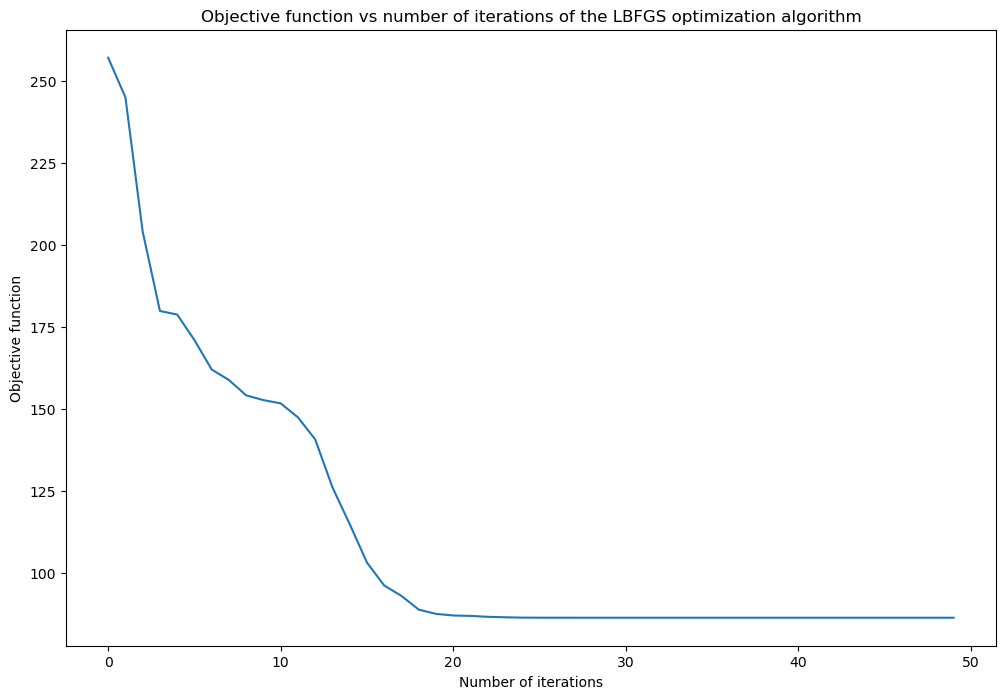

In [39]:
plt.plot(np.arange(0,50), opt_history)
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.title("Objective function vs number of iterations of the LBFGS \
optimization algorithm")

### Compare output of optimizer and values given in f2b.txt  {-}

In [40]:
T_A_opt = T_opt[0:3, 0:3]
T_b_opt = T_opt[:, 3:]

A_prime_opt = T_A_opt.detach().numpy()
b_prime_opt = T_b_opt.detach().numpy()

A_opt, b_opt = my_pytorch_affine_to_numpy_affine(A_prime_opt, b_prime_opt, I_ref.shape)
A_opt, b_opt

(array([[ 1.00105293, -0.02573523, -0.0409465 ],
        [ 0.04238337,  1.00019654,  0.09941294],
        [ 0.05351439, -0.10724943,  0.99416957]]),
 array([[ 5.61158738],
        [-5.73518851],
        [23.43572295]]))

In [41]:
A, b = my_read_transform("data/f2b.txt")
A, b

(array([[ 1.0003, -0.0254, -0.0409],
        [ 0.0416,  1.001 ,  0.0989],
        [ 0.0537, -0.107 ,  0.9939]]),
 array([[ 5.6887],
        [-5.8519],
        [23.4575]]))

### Visualize resliced image  {-}

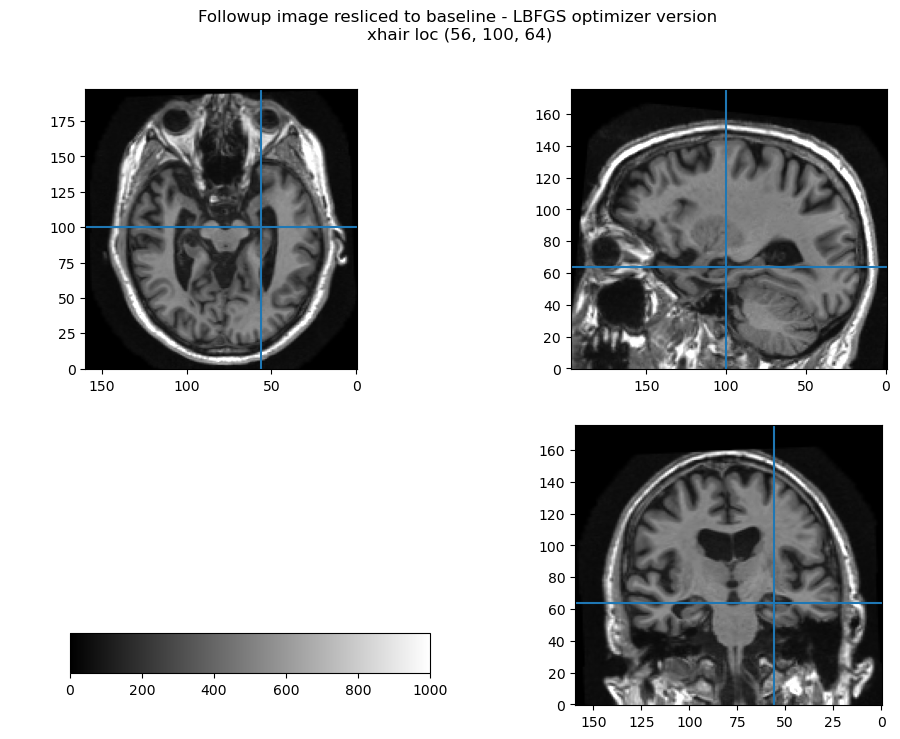

In [42]:
T_res_opt = my_transform_image_pytorch(T_ref, T_mov, T_A_opt, T_b_opt)

my_view(T_res_opt.squeeze().detach().cpu().numpy(), xhair=(56,100,64), 
        header=hdr_mov, crange=(0,1000),
        title="Followup image resliced to baseline - LBFGS optimizer version")


## Objective function - using Gaussian blurring before optimization  {-}

In [43]:
T_opt = torch.tensor(np.eye(3,4), requires_grad=True)

I_ref_lpf = my_gaussian_lpf(I_ref, sigma=5)
I_mov_lpf = my_gaussian_lpf(I_mov, sigma=5)

T_ref_lpf = torch.from_numpy(I_ref_lpf).unsqueeze(0).unsqueeze(0)
T_mov_lpf = torch.from_numpy(I_mov_lpf).unsqueeze(0).unsqueeze(0)

# Objective function for optimization, a wrapper around my_affine_objective_fn
f_opt = lambda : my_affine_objective_fn(T_ref_lpf, T_mov_lpf, T_opt[0:3,0:3], 
                                        T_opt[0:3,3].unsqueeze(1))

# Initialize the LBFGS optimizer with a line search routine
optimizer = torch.optim.LBFGS([T_opt], history_size=10, max_iter=4, 
                              line_search_fn="strong_wolfe")

# Keep track of the objective function values over the course of optimization
opt_history = []

# Run for a few iterations
for i in range(50):
    optimizer.zero_grad()
    objective = f_opt()
    objective.backward()
    optimizer.step(f_opt) 
    opt_history.append(objective.item())
    print('Iter %03d Obj %8.4f' % (i, objective.item()))

Iter 000 Obj 109.5962
Iter 001 Obj  78.5132
Iter 002 Obj  63.2004
Iter 003 Obj  62.8843
Iter 004 Obj  53.3542
Iter 005 Obj  51.3732
Iter 006 Obj  46.0957
Iter 007 Obj  45.2365
Iter 008 Obj  44.4188
Iter 009 Obj  43.2895
Iter 010 Obj  42.6280
Iter 011 Obj  42.5678
Iter 012 Obj  42.5523
Iter 013 Obj  42.5325
Iter 014 Obj  42.4971
Iter 015 Obj  42.4803
Iter 016 Obj  42.4738
Iter 017 Obj  42.4733
Iter 018 Obj  42.4733
Iter 019 Obj  42.4733
Iter 020 Obj  42.4733
Iter 021 Obj  42.4733
Iter 022 Obj  42.4733
Iter 023 Obj  42.4733
Iter 024 Obj  42.4733
Iter 025 Obj  42.4733
Iter 026 Obj  42.4733
Iter 027 Obj  42.4733
Iter 028 Obj  42.4733
Iter 029 Obj  42.4733
Iter 030 Obj  42.4733
Iter 031 Obj  42.4733
Iter 032 Obj  42.4733
Iter 033 Obj  42.4733
Iter 034 Obj  42.4733
Iter 035 Obj  42.4733
Iter 036 Obj  42.4733
Iter 037 Obj  42.4733
Iter 038 Obj  42.4733
Iter 039 Obj  42.4733
Iter 040 Obj  42.4733
Iter 041 Obj  42.4733
Iter 042 Obj  42.4733
Iter 043 Obj  42.4733
Iter 044 Obj  42.4733
Iter 045 O

### Objective function vs number of iterations - Gaussian blurring  {-}

Text(0.5, 1.0, 'Objective function vs number of iterations - Gaussian blurring before LBFGS optimization algorithm')

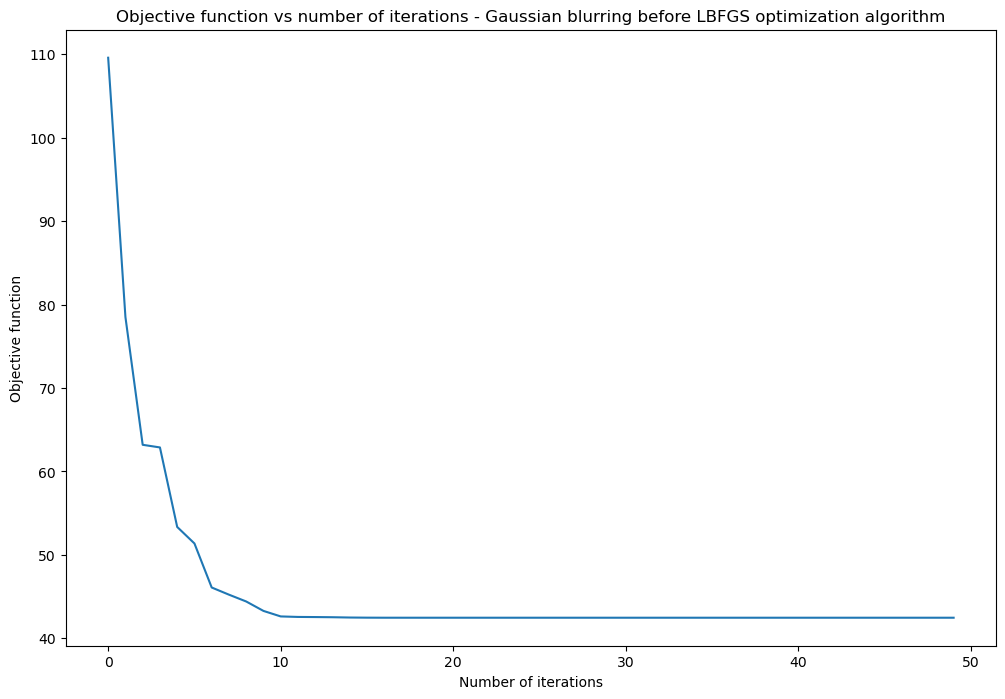

In [44]:
plt.plot(np.arange(0,50), opt_history)
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.title("Objective function vs number of iterations - Gaussian blurring \
before LBFGS optimization algorithm")

### Compare output of optimizer and values given in f2b.txt  {-}

In [45]:
T_A_opt = T_opt[0:3, 0:3]
T_b_opt = T_opt[:, 3:]

A_prime_opt = T_A_opt.detach().numpy()
b_prime_opt = T_b_opt.detach().numpy()

A_opt, b_opt = my_pytorch_affine_to_numpy_affine(A_prime_opt, b_prime_opt, 
                                                 I_ref.shape)
A_opt, b_opt

(array([[ 1.01906413, -0.0229889 , -0.04863879],
        [ 0.03708388,  1.00635721,  0.08491381],
        [ 0.06316525, -0.11051365,  0.97133745]]),
 array([[ 4.52640017],
        [-5.44740872],
        [25.45131537]]))

In [46]:
A, b

(array([[ 1.0003, -0.0254, -0.0409],
        [ 0.0416,  1.001 ,  0.0989],
        [ 0.0537, -0.107 ,  0.9939]]),
 array([[ 5.6887],
        [-5.8519],
        [23.4575]]))

### Visualize resliced image - using `T_opt` from Gaussian blurring  {-}

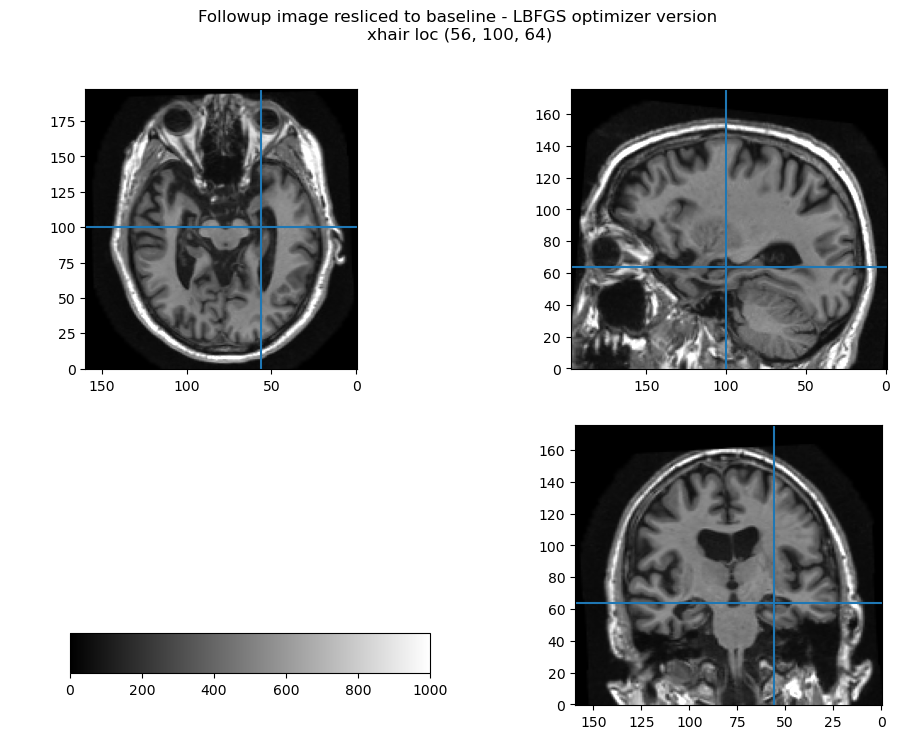

In [47]:
T_res_opt = my_transform_image_pytorch(T_ref, T_mov, T_A_opt, T_b_opt)

my_view(T_res_opt.squeeze().detach().cpu().numpy(), xhair=(56,100,64), 
        header=hdr_mov, crange=(0,1000),
        title="Followup image resliced to baseline - LBFGS optimizer version")

The optimization algorithm converges much quicker when we apply Gaussian smoothing to the images before running it. The affine transform produced this way is not too different from the original affine transform. Visually there doesn't appear to be many differences either.